In [30]:
from py2cfg import CFGBuilder
import re

In [31]:
def ParseGraph(cfg):
    i = -1
    nodes = []
    for block in cfg:
            current = []
            neighbours = []
            source = str(i) +" : "+ str(block.get_source())
            source = source.strip("\n")
            node = re.findall("\d*@", str(block))[0]
            node = int(node[:-1])
            if (node != "1"):
                for e in block.exits:
                    neighbour = re.findall("\d*@", str(e))[1]
                    neighbour = int(neighbour[:-1])
                    neighbours.append(neighbour)
            current.append(i)
            current.append(node)
            current.append(neighbours)
            current.append(source)
            nodes.append(current)
            i += 1

    nodes.pop(0)

    return nodes

In [32]:
def FormatGraph(nodes):
	
	#gera um dicionario que sera usado para substituir os valores do py2cfg por numeros em ordem crescente, 
    # o metodo do py2cfg corta nos nos redundantes, deixando referencias fantasmas no grafo original, necessitando essa limpeza da saida para podermos manipular

    dict = {}
    for node in nodes:
        dict[node[1]] = node[0]

    #substitui os nós vizinhos de cada nó usando o dicionario
    for node in nodes:
        for idx, neighbour in enumerate(node[2]):
            node[2][idx] = dict[neighbour]

    # remove o agora redundante valores antigos de index do py2cfg
    for node in nodes:
        node.pop(1)

    # resultado final, uma lista de nós, contendo seus vizinhos e o tamanho do grafo

    return nodes

In [33]:
def GerarRequisitos(nodes):
	
    R1, R2, R3 = [], [], []

	# gera primeira lista de requisitos de nós, percorendo a lista e registrando os nós existentes 
    for node in nodes:
        R1.append(node[0])

    # gera lista de requisitos de arcos, percorendo a lista e explorando os vizinhos
    for node in nodes:
        for idx, neighbour in enumerate(node[1]):
            R2.append([node[0],node[1][idx]])

    # gera lista de requisitos de par de arcos, percorendo a lista e explorando os vizinhos
    for node in nodes:
        for idx1, neighbour1 in enumerate(node[1]):
            if len(nodes[neighbour1][1]) == 0:
                if len(R3) == 0:
                    R3.append([node[0],node[1][idx1]])
            for idx2, neighbour2 in enumerate(nodes[neighbour1][1]):
                R3.append([node[0],node[1][idx1],nodes[neighbour1][1][idx2]])

    return [R1,R2,R3]

In [34]:
def CreatePath(nodes, path, tests, requisitos, limit, depth):
	#caso de quebra onde profundidade passou do limite da recursividade
	if depth > limit:
		return tests
	#caso inicial de um caminho vazio
	if path == []:
		for element in nodes:
			if not element[1]:
				path.insert(0, element[0])
				depth = depth + 1
				tests = CreatePath(nodes, path, tests, requisitos, limit, depth)
				depth = depth - 1
				path.pop(0)
	#caso onde é encontrado o no inicial 0 do grafo, então é avaliado se o caminho esta completando algum requisito novo
	elif path[0] == 0:
		i = 0
		new = False
		while i+2 < len(path):
			requisito = [path[i],path[i+1],path[i+2]]
			if requisito in requisitos:
				new = True
				requisitos.remove(requisito)
			i += 1
		if len(path) == 2:
			requisito = [path[i],path[i+1]]
			if requisito in requisitos:
				new = True
				requisitos.remove(requisito)
		if new:
			tests.append(path.copy())
	#caso aonde a raiz do grafo nao foi encontrado
	elif path[0] != 0:
		for element in nodes:
			if path[0] in element[1]:
				path.insert(0, element[0])
				depth = depth + 1
				tests = CreatePath(nodes, path, tests, requisitos, limit, depth)
				depth = depth - 1
				path.pop(0)
	return tests

In [35]:
def SuggestTest(nodes, requisitos, limit):
	requisitosFaltantes = requisitos.copy()
	requisitosTestes = requisitos.copy()
	tests = []
	compliance = []
	#busca criar caminhos coma  função createpatha te a lista de requisitos estar vazia, com um limite inicial 
	while requisitosTestes:
		tests = CreatePath(nodes, [], tests, requisitosTestes, limit, 0)
		limit = limit+1

	for test in tests:
			compliancetemp = []
			i = 0
			while i+2 < len(test):
				requisito = [test[i],test[i+1],test[i+2]]
				print(requisito)
				if requisito in requisitosFaltantes:
					compliancetemp.append(requisito)
					requisitosFaltantes.remove(requisito)
				i += 1
			if len(test) == 2:
				requisito = [test[i],test[i+1]]
				if requisito in requisitosFaltantes:
					compliancetemp.append(requisito)
					requisitosFaltantes.remove(requisito)
			compliance.append(compliancetemp)

	return tests, compliance

In [36]:
import graphviz
def CreateGraphviz(nodes):
	#recriação do grafo em Graphviz
	G = graphviz.Digraph(node_attr={'shape':'ellipse'},format='svg')

	for node in nodes:
		i = 0
		if "if" in str(node[2]):
			G.node(str(node[0]),label = node[2], shape = "diamond", color = "red")
		elif "while" in str(node[2]):
			G.node(str(node[0]),label = node[2], shape = "polygon", color = "orange")
		elif "for" in str(node[2]):
			G.node(str(node[0]),label = node[2], shape = "octagon", color = "orange")
		elif "try" in str(node[2]):
			G.node(str(node[0]),label = node[2], shape = "Mdiamond", color = "orange")
		elif "return" in str(node[2]):
			G.node(str(node[0]),label = node[2], shape = "parallelogram", color = "green")
		else:
			G.node(str(node[0]),node[2])
		for son in node[1]:
			if i == 0 :
				if len(node[1]) == 2:
					G.edge(str(node[0]), str(son), color = "green")
				else:
					G.edge(str(node[0]), str(son), color = "black")
			elif i == 1 :
				G.edge(str(node[0]), str(son), color = "red")
			else:
				G.edge(str(node[0]), str(son))
			i+= 1

	return G

In [37]:
def GeradorDeRequisitos(filepath, filename):
    cfg = CFGBuilder().build_from_file('example', filepath)
    
    nodes = FormatGraph(ParseGraph(cfg))
    requisitos = GerarRequisitos(nodes)
    requisitosTestes = requisitos.copy()
    Graph = CreateGraphviz(nodes)
    name = "requisitos " + filename +".txt" 
    testes, compliance = SuggestTest(nodes, requisitosTestes[2], 3)
    requisitos[0] = "requisitos de nós (" + str(len(requisitos[0])) + ") : " + str(requisitos[0])
    requisitos[1] = "requisitos de arcos (" + str(len(requisitos[1])) + ") : " + str(requisitos[1])
    requisitos[2] = "requisitos de par de arcos (" + str(len(requisitos[2])) + ") : " + str(requisitos[2])

    testesPropostos = []
    i = 0
    for teste in testes:
        testesPropostos.append("T"+ str(i) + ": " + str(teste))
        i += 1

    with open(name, 'w') as file:
        file.write(str(requisitos[0]) + '\n')
        file.write(str(requisitos[1]) + '\n')
        file.write(str(requisitos[2]) + '\n\n\n')

        i = 0
        for proposta in testesPropostos:
            file.write(str(proposta) + '\n')
            file.write(str(compliance[i]) + '\n\n\n')
            i += 1
    print(Graph.source)
    Graph.render("problem_solution", view = True)
    print('display')
    display(Graph)
    print('end display')
    return nodes

[0, 1, 3]
[0, 1, 2]
[1, 2, 1]
[2, 1, 3]
[0, 1, 2]
[1, 2, 1]
[2, 1, 2]
[1, 2, 1]
[2, 1, 3]
digraph {
	node [shape=ellipse]
	0 [label="0 : fat = 1"]
	0 -> 1 [color=black]
	1 [label="1 : while n > 0:" color=orange shape=polygon]
	1 -> 2 [color=green]
	1 -> 3 [color=red]
	2 [label="2 : fat = fat * n
n = n - 1"]
	2 -> 1 [color=black]
	3 [label="3 : return fat" color=green shape=parallelogram]
}

display


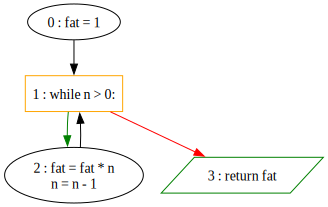

end display
[0, [1], '0 : fat = 1']
[1, [2, 3], '1 : while n > 0:']
[2, [1], '2 : fat = fat * n\nn = n - 1']
[3, [], '3 : return fat']


In [38]:
filename = "problem_solution"
nodes = GeradorDeRequisitos("./"+filename+".py", filename)
for n in nodes:
    print(n)